<a href="https://colab.research.google.com/github/vitamin1312/MLc/blob/main/text_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install -Uq transformers

In [18]:
import torch
from fastai.text.all import *
import numpy as np

In [19]:
from transformers import AutoTokenizer, AutoModelForCausalLM
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")
model = AutoModelForCausalLM.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")

In [20]:
ids = tokenizer.encode('Подумал мужик')
ids

[672, 721, 14375, 14937]

In [21]:
tokenizer.decode(ids)

'Подумал мужик'

In [22]:
t = torch.LongTensor(ids)[None]
preds = model.generate(t)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [23]:
preds.shape, preds[0]

(torch.Size([1, 20]),
 tensor([  672,   721, 14375, 14937,    16,   374,   827,   373,   492,   685,
           282,  4349,    16,   502,   492,   373,   322,  1559,   453,  2240]))

In [24]:
tokenizer.decode(preds[0])

'Подумал мужик, что если бы он был в состоянии, то он бы не стал так делать'

In [25]:
# path = untar_data(URLs.WIKITEXT_TINY)
# path.ls()

In [26]:
df = pd.read_csv('/content/drive/MyDrive/text genneration/b_cat.csv')
length = int(len(df)*0.95)
# df

In [27]:
for index, message in enumerate(df['text']):

    if type(message) != str or "t.me" in message or "None" in message or "Channel" in message or "Подпишись" in message or "http" in message:
        df = df.drop(index=index, axis=1)

df_train = df.iloc[:length].copy()
df_valid = df.iloc[length:].copy()
# df.head()

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6698 entries, 0 to 6804
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6698 non-null   object
 1   date    6698 non-null   object
dtypes: object(2)
memory usage: 157.0+ KB


In [29]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6466 entries, 0 to 6570
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6466 non-null   object
 1   date    6466 non-null   object
dtypes: object(2)
memory usage: 151.5+ KB


In [30]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 232 entries, 6571 to 6804
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    232 non-null    object
 1   date    232 non-null    object
dtypes: object(2)
memory usage: 5.4+ KB


In [31]:
all_texts = np.concatenate([df_train.iloc[:, 0].values, df_valid.iloc[:, 0].values])

In [32]:
words_freq = dict()

for text in all_texts:
    words = text.split()
    for word in words:

        if word in words_freq.keys():
            words_freq[word] += 1
        else:
            words_freq[word] = 1
words_freq = dict(sorted(words_freq.items(), key=lambda item: item[1]))

In [33]:
# for pair in words_freq.items():
#     print(pair)

In [34]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x):
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [35]:
splits = [range_of(df_train), list(range(len(df_train), len(all_texts)))]
tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [36]:
tls.train[0], tls.valid[0]

(tensor([  677, 20283, 43061, 16337,   374,    17,   299, 17059]),
 tensor([11648,   288,   487,  1871, 19990,  1711,   334, 25999,  2197,  2107,
          2548,    17, 46366,   774,   303, 11284,   685, 24058,  9256,  6162,
         23698,  2006,  1653, 34174,  9231,   513,   315,    35]))

In [37]:
tls.tfms(tls.train.items[0]).shape, tls.tfms(tls.valid.items[0]).shape

(torch.Size([8]), torch.Size([28]))

In [38]:
show_at(tls.train, 0)

В институте интриг открыли что-то интересное


In [39]:
show_at(tls.valid, 0)

Ползут две черепахи по пустыне одна другой говорит-Вчера гололёд был?-Нет.-Тогда почему всё песком посыпано?


In [40]:
bs, sl = 8, 16
dls = tls.dataloaders(bs=bs, seq_len=sl)

In [41]:
dls.show_batch(max_n=2)

,text,text_
0,Как называют гея со стажем?Пидор-асФилолог,называют гея со стажем?Пидор-асФилолог приходит
1,Н-О-В-О.— Да странное слово в словаре нет.,-О-В-О.— Да странное слово в словаре нет. А


In [42]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [43]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [44]:
learn.validate()

(#2) [5.274146556854248,195.2238006591797]

SuggestedLRs(valley=4.365158383734524e-05)

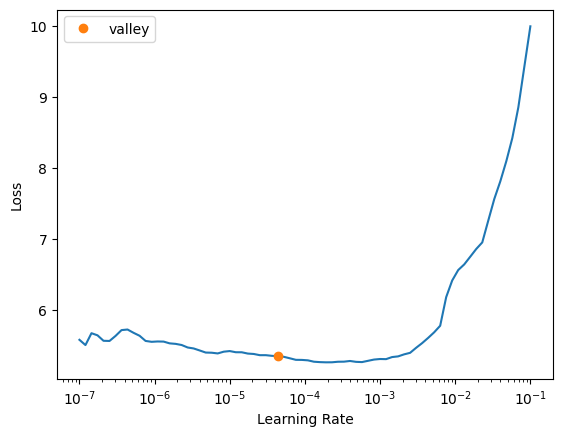

In [45]:
learn.lr_find()

In [46]:
# learn.fine_tune(4, 1e-4)

In [47]:
learn.fine_tune(3, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,4.733221,4.503832,90.362724,04:41


epoch,train_loss,valid_loss,perplexity,time
0,4.095793,4.204176,66.965393,04:43
1,3.708946,3.997756,54.475742,04:44
2,3.310698,3.985859,53.831520,04:45


In [48]:
learn.fit_one_cycle(1, 1e-6)

epoch,train_loss,valid_loss,perplexity,time
0,2.997160,4.000963,54.650764,04:44


In [62]:
prompt = "В дверь постучали десять раз. Штирлиц подумал и"

In [63]:
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp

tensor([[  677,  2979, 17976,   414,  4705,   445,    18,  1034, 10627, 30952,
          4507,   289]], device='cuda:0')

In [66]:
preds = learn.model.generate(inp, max_length=30, num_beams=50, temperature=50);

In [67]:
tokenizer.decode(preds[0].cpu().numpy())

'В дверь постучали десять раз. Штирлиц подумал и открыл.В дверь постучали десять раз.Штирлиц подумал ещё подумал ещё подумал ещё'

In [53]:
# torch.save(learn.model, '/content/drive/MyDrive/text genneration/sber_gpt3_4.pkl')